# Image Classification
* Date: 29/06/2021
* Author: Vivek Kumar
* Type of Model: TSR (Classification)
* Status:Draft

### Metadata
* Dataset: Traffic sign recognization
* Size of training set:31367
* Size of testing set : 7842
* Size of validation set : 12630
* Number of class :43 
* Original Model: CNN

### Outcomes
* Accuracy of model: 0.97

    * Observations: 
    * Remarks: 
    * Learning:
    * Next things: 
    
### Peer Review
* Reviewer:
* Review Date:
* Review Comments:


# 1.0 Prepare Environment

In [1]:
"""Description : import packages"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time,random
import cv2
from skimage import io,color,exposure,transform
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os,glob


import tensorflow as tf
from keras.utils.vis_utils import plot_model

#setting seed for this code
np.random.seed(seed=42)

In [2]:
"""Description: formating time string"""
def hms_string(sec_elapsed):
    h=sec_elapsed//(60*60)
    m=(sec_elapsed %(60*60))//60
    s=sec_elapsed % 60
    return f'{h}:{m:>02}:{s:>02.2f}'

# 2.0 Data loading and Preprocessing

In [3]:
IMG_SIZE=48
num_classes=43

### 2.1 Function to Preprocess Image

In the RGB representation the hue and the luminosity are expressed as a linear combination of the R,G,B channels, whereas they correspond to single channels of the HSV image (the Hue and the Value channels).

Histogram equalization method usually increases the global contrast of many images, especially when the image is represented by a narrow range of intensity values. Through this adjustment, the intensities can be better distributed on the histogram utilizing the full range of intensities evenly.

In [4]:
def preprocess_img(img,IMG_SIZE=IMG_SIZE):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
#     img = np.rollaxis(img,-1)

    return img

### 2.2 Preprocess all training images into a numpy array

In [5]:
file_path=r'D:\Data'

In [6]:
def prepare_data(classes=num_classes,file_path=file_path):
    data = []
    labels = []
    for i in tqdm(range(classes)):
        path = os.path.join(file_path,'Train',str(i))
        images = os.listdir(path)
        for a in images:
            try:
                img = cv2.imread(path + '\\'+ a)
                img=preprocess_img(img)

                data.append(img)
                labels.append(i)
            except Exception as e:
                print(e)
    return np.array(data),np.array(labels)

In [7]:
X,y=prepare_data(classes=num_classes,file_path=file_path)

In [8]:
print(X.shape, y.shape)

(39209, 48, 48, 3) (39209,)


In [9]:
np.bincount(y)

array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
       1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
        390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
        689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240],
      dtype=int64)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
'''
Description : check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of x_train:  (31367, 48, 48, 3)
shape of y_train: (31367,)
shape of x_test: (7842, 48, 48, 3)
shape of y_test: (7842,)


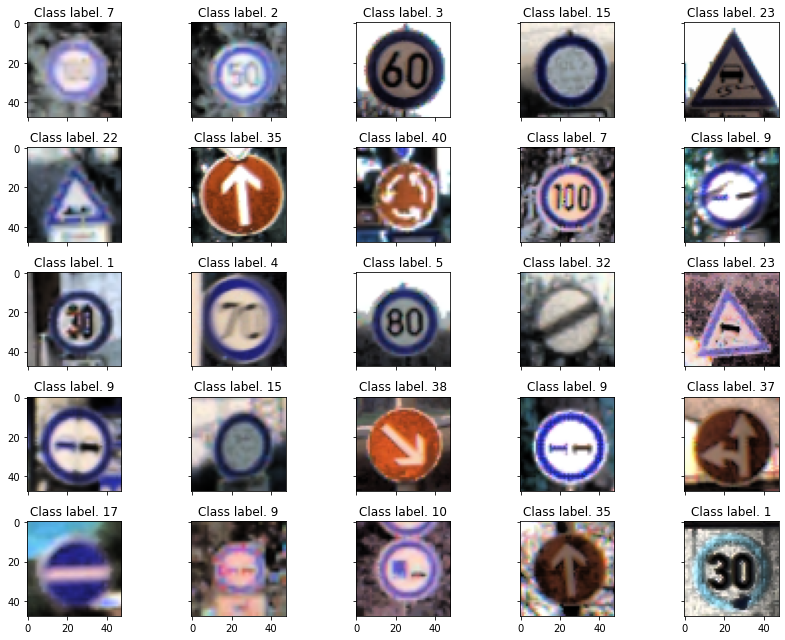

In [13]:
'''
Description: visualize few training dataset
'''
rows=5

random_indices=random.sample(range(X_train.shape[0]),rows*rows)
sample_images=X_train[random_indices,:]
sample_labels=y_train[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:],cmap='gray')
    axs[subplot_row,subplot_col].set_title("Class label. %d" % sample_labels[i])
plt.tight_layout()

In [14]:
'''
Description: convert class vector to binary (one hot encoder) metrix
'''
y_train=tf.keras.utils.to_categorical(y_train,num_classes)
y_test=tf.keras.utils.to_categorical(y_test,num_classes)

In [15]:
'''
Description : check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of x_train:  (31367, 48, 48, 3)
shape of y_train: (31367, 43)
shape of x_test: (7842, 48, 48, 3)
shape of y_test: (7842, 43)


# 3.0 Model Development and Training

In [15]:
def CNN_model(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    #create sequential model
    model=tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512,activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    
    #compile the model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [16]:
model=CNN_model()

In [17]:
plot_model(model,show_layer_names=True,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
#train model
def train_model(model=model,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,batch_size=64,epochs=5,filename='Traffic_sign_recognition'):
    # Callbacks
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filename+'.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
    ES=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')
    #train model
    
    model.summary()
    start_time=time.time()
    history=model.fit(X_train,y_train,epochs=epochs,verbose=1, callbacks=[ES,checkpoint],validation_data=(X_test,y_test))#tensorboard_callback,,validation_split=0.05
    
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))
    
    return model,history

In [19]:
model,history=train_model(epochs=15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0

In [20]:
#define function to plot training loss and accuracy
def plot_model(training_history):
    loss=training_history.history['loss']
    accuracy=training_history.history['accuracy']
    val_loss=training_history.history['val_loss']
    val_accuracy=training_history.history['val_accuracy']
    epochs_range=np.arange(1,len(loss)+1)
    
    plt.figure(figsize=(16,9))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.title("Training loss ")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Loss",fontsize=16,fontweight='bold')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range,accuracy,label="Training Accuracy")
    plt.plot(epochs_range,val_accuracy,label="Validation Accuracy")
    plt.title("Training accuracy")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Accuracy",fontsize=16,fontweight='bold')
    plt.legend()

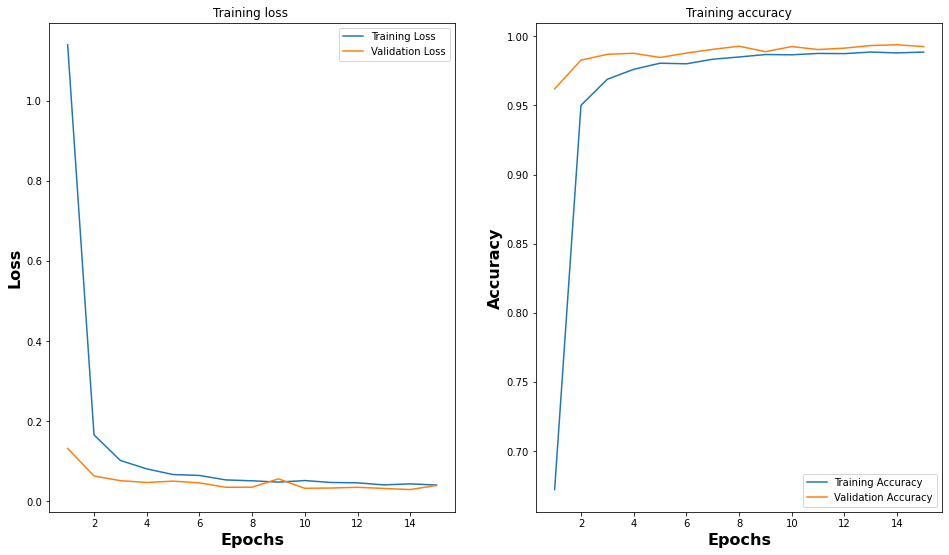

In [21]:
plot_model(history)

In [22]:
#load best saved model
model=tf.keras.models.load_model("Traffic_sign_recognition.h5")

## 3.1 Validate model  accuracy

In [23]:
val_path=r'D:\Data\Test'

In [24]:
test = pd.read_csv('D:\Data\Test.csv')
test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [25]:
X_val = []
y_val = []
i = 0
for file_name, class_id  in tqdm(zip(list(test['Path']), list(test['ClassId']))):
    try:
        img_path = os.path.join(val_path,file_name[5:])
        img=cv2.imread(img_path)
        X_val.append(preprocess_img(img))
        y_val.append(class_id)
    except Exception as e:
                print(e)
    
X_val = np.array(X_val)
y_val = np.array(y_val)

In [26]:
print(f'X_val shape is: {X_val.shape}')
print('y_val shape is: {}'.format(y_val.shape))

X_val shape is: (12630, 48, 48, 3)
y_val shape is: (12630,)


In [27]:
y_pred = np.argmax(model.predict(X_val),axis=-1)
y_pred[:10]

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35], dtype=int64)

In [28]:
acc = np.sum(y_pred==y_val)/np.size(y_pred)
print("Validation accuracy = {}".format(acc))

Validation accuracy = 0.9678543151227237


In [29]:
metrics.confusion_matrix(y_val, y_pred)

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 713,   1, ...,   1,   0,   0],
       [  0,   1, 748, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  81,   0,   0],
       [  0,   0,   0, ...,   0,  46,   0],
       [  0,   0,   0, ...,   0,   0,  81]], dtype=int64)

In [30]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      0.99      0.98       720
           2       0.99      1.00      0.99       750
           3       0.98      0.96      0.97       450
           4       1.00      0.97      0.99       660
           5       0.92      0.97      0.94       630
           6       0.97      0.75      0.85       150
           7       0.97      0.99      0.98       450
           8       0.98      0.96      0.97       450
           9       0.97      1.00      0.98       480
          10       0.99      0.98      0.99       660
          11       0.98      0.93      0.95       420
          12       0.99      1.00      0.99       690
          13       0.96      1.00      0.98       720
          14       1.00      0.89      0.94       270
          15       0.97      0.98      0.97       210
          16       0.99      0.99      0.99       150
          17       1.00    